# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS-109A Introduction to Data Science 


## Fine Particulate Air Pollution and COVID-19

**Harvard University**<br>
**Spring 2020**<br>
Jack Luby, Hakeem Angulu, and Louie Ayre <br>

---



### The Problem

Fine particulate matter (PM$_{2.5}$) is an air pollutant which has been shown to increase the risk of mortality and hospitalization in exposed populations. 

The fine inhalable particles of PM$_{2.5}$ impact communitites at the local level, incrementally decreasing their life expectancies as ambient concentrations of the pollutant rise. Despite their adverse effects, concentrations of PM$_{2.5}$ are not well monitored throughout much of the United States (especially in regions of low population density). As a result, many communities (and their care providers) are unaware of the life-shortening ambient concentrations of PM$_{2.5}$ they breathe each day. 

These risks have been heightened by the coronavirus pandemic. COVID-19 is primarily a respiratory disease, and PM$_{2.5}$'s adverse effects on respiratory potential have been theorized and shown to increase the likelihood of developing COVID-19. It is apparent that high concentrations of PM$_{2.5}$ are likely to be founded in rural and low-income communities and communities of color. In addition, the US healthcare and social systems have long underserved those communities. The combination of these factors creates an especially bad prognosis for those communities, and necessitates further study and rapid policy and healthcare interventions.

### Our Project

With PM$_{2.5}$ data and COVID-19 data at hand, this project seeks to understand the relationships between PM$_{2.5}$ pollution, demographic and socioeconomic factors, and COVID-19, with a particular focus on rural and low-income communities, and communities of color.

# Feed Forward Neural Network Modeling and Analysis

In [ ]:
## Set formatting to CS109 standard
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

In [2]:
# The classics
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt

In [3]:
# Neural Network imports
import tensorflow as tf

from tensorflow.keras import backend
from tensorflow.keras.models import model_from_json

print(tf.keras.__version__)
print(tf.__version__)

2.2.4-tf
2.1.0


In [4]:
# SHAP analysis import
import shap

## Data Import

In [5]:
main_df = pd.read_csv("data/unnormalized.csv")

In [6]:
main_df.head()

,fips,pm25,poverty,pop_density,med_house_value,pct_blk,med_household_income,pct_owner_occ,pct_hispanic,education,...,liquor_stores_open,firearms_sellers_open,days_since_closing_restaurants_except_takeout,days_since_closing_gyms,days_since_closing_movie_theaters,froze_evictions,order_freezing_utility_shutoffs,infection_rate,death_rate,death_rate_amongst_infected
0,1001,8.548029,0.153784,92.859925,147900.0,0.191395,58786.0,0.748946,0.027681,0.201884,...,1,1,52,43,43,0,0,0.000960,0.000054,0.056604
1,1003,7.522474,0.105661,130.901888,189800.0,0.094970,55962.0,0.736193,0.044943,0.182423,...,1,1,52,43,43,0,0,0.000908,0.000024,0.026455
2,1005,8.085884,0.288633,29.132136,92900.0,0.475758,34186.0,0.613978,0.042898,0.315394,...,1,1,52,43,43,0,0,0.001823,0.000039,0.021277
3,1007,8.746719,0.139877,36.190198,96500.0,0.222755,45340.0,0.750731,0.024282,0.244739,...,1,1,52,43,43,0,0,0.001909,0.000000,0.000000
4,1009,8.215674,0.144003,89.395550,124700.0,0.014954,48695.0,0.786262,0.091266,0.268941,...,1,1,52,43,43,0,0,0.000694,0.000000,0.000000


In [7]:
responses = ['infection_rate', 'death_rate', 'death_rate_amongst_infected']

X_train, X_test, y_train, y_test = train_test_split(main_df.drop(responses + ['fips'], axis=1),
                                                    main_df[responses], test_size=0.2,
                                                    random_state=109)

In [8]:
X_train.shape

(2272, 26)

In [9]:
y_train.shape

(2272, 3)

## Model Definition

The researchers built a Feed Forward Neural Network (FFNN) to do analysis on the data. Of the neural networks available (CNN, RNN, Autoencoders, etc.), the FFNN was best suited to the shape and type of data. The data were neither images nor sequential, and thus lent itself well to a simple FFNN.

In [286]:
# Hyperparameters
n_predictors = X_train.shape[-1]
n_responses = 3
drop_rate = .2

optimizer = "adam"
loss = "mse"
metrics = ["accuracy"]

batch_size = 1
epochs = 15
validation_split = 0.1
verbose = 2

A simple, shallow architecture was used, in part because of the small size of the dataset. With only $2272$ observations in the dataset, deep learning would have not yielded any better results. It was tried, and the model overfit very quickly.

In [293]:
# Define model
model = tf.keras.Sequential(name='FFNN')
model.add(tf.keras.layers.Dense(n_predictors, activation="sigmoid", input_dim=n_predictors, name='slp'))
model.add(tf.keras.layers.Dropout(drop_rate, name='dropout'))
model.add(tf.keras.layers.Dense(n_responses, activation="linear", name='output'))

# Compile model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [294]:
model.summary()

Model: "FFNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
slp (Dense)                  (None, 26)                702       
_________________________________________________________________
dropout (Dropout)            (None, 26)                0         
_________________________________________________________________
output (Dense)               (None, 3)                 81        
Total params: 783
Trainable params: 783
Non-trainable params: 0
_________________________________________________________________


## Model Training

In [295]:
# Define early stopping callback
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

In [296]:
# Don't re-train
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
                    validation_split=validation_split, verbose=verbose,
                    callbacks=[es])

Train on 2044 samples, validate on 228 samples
Epoch 1/15
2044/2044 - 2s - loss: 0.1257 - accuracy: 0.4154 - val_loss: 0.0015 - val_accuracy: 0.5307
Epoch 2/15
2044/2044 - 2s - loss: 0.0058 - accuracy: 0.4388 - val_loss: 0.0012 - val_accuracy: 0.5263
Epoch 3/15
2044/2044 - 2s - loss: 0.0019 - accuracy: 0.4403 - val_loss: 0.0011 - val_accuracy: 0.5044
Epoch 4/15
2044/2044 - 2s - loss: 0.0018 - accuracy: 0.5020 - val_loss: 0.0012 - val_accuracy: 0.4956
Epoch 5/15
2044/2044 - 2s - loss: 0.0017 - accuracy: 0.5113 - val_loss: 0.0012 - val_accuracy: 0.4956
Epoch 6/15
2044/2044 - 2s - loss: 0.0017 - accuracy: 0.5054 - val_loss: 0.0011 - val_accuracy: 0.4956
Epoch 7/15
2044/2044 - 2s - loss: 0.0017 - accuracy: 0.5176 - val_loss: 0.0011 - val_accuracy: 0.4956
Epoch 8/15
2044/2044 - 2s - loss: 0.0017 - accuracy: 0.5181 - val_loss: 0.0012 - val_accuracy: 0.4956
Epoch 9/15
2044/2044 - 2s - loss: 0.0017 - accuracy: 0.5098 - val_loss: 0.0013 - val_accuracy: 0.4956
Epoch 00009: early stopping


## Model Analysis

In [195]:
# Plot history
def plot_loss(history):
    loss = history['loss']
    val_loss = history['val_loss']
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(12, 8))
    plt.plot(epochs, loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'b--', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

In [136]:
# Plot history
def plot_accuracy(history):
    accuracy = history['accuracy']
    val_accuracy = history['val_accuracy']
    epochs = range(1, len(accuracy) + 1)

    plt.figure(figsize=(12, 8))
    plt.plot(epochs, accuracy, 'g-', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'g--', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

In [137]:
# Store model
def store_keras_model(model, model_name):
    model_json = model.to_json() # serialize model to JSON
    with open("./models/{}.json".format(model_name), "w") as json_file:
        json_file.write(model_json)
    model.save_weights("./models/{}.h5".format(model_name)) # serialize weights to HDF5
    print("Saved model to disk")
    
# Load model 
def load_keras_model(model_name):
    # Load json and create model
    json_file = open('./models/{}.json'.format(model_name), 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = tf.keras.models.model_from_json(loaded_model_json)
    # Load weights into new model
    model.load_weights("./models/{}.h5".format(model_name))
    return model

In [264]:
# Save training history
hist_df = pd.DataFrame(history.history)
hist_df.to_csv("models/history_ffnn.csv", index=False)

In [265]:
# Save model
store_keras_model(model, 'model_FFNN')

Saved model to disk


In [266]:
# Load history
history = pd.read_csv("models/history_ffnn.csv")

The loss and accuracy histories of the model are plotted below. As the loss rapidly approaches $0$, and the accuracy approaches $1$, we run the risk of overfitting. The model was regularized with Dropout and early stopping to help mitigate this.

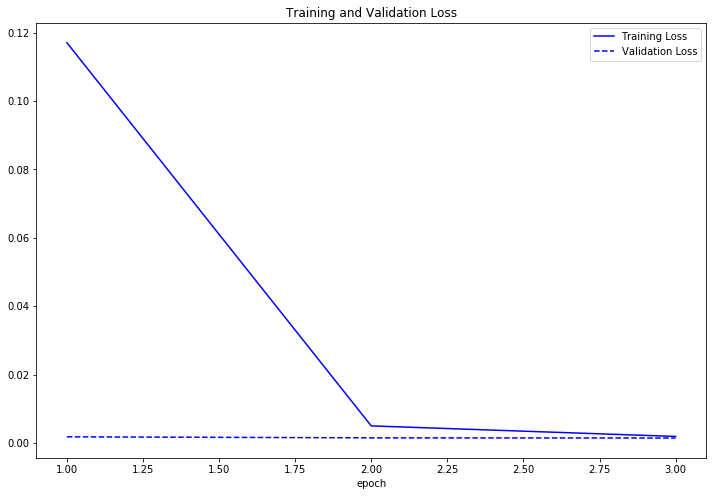

In [267]:
plot_loss(history)

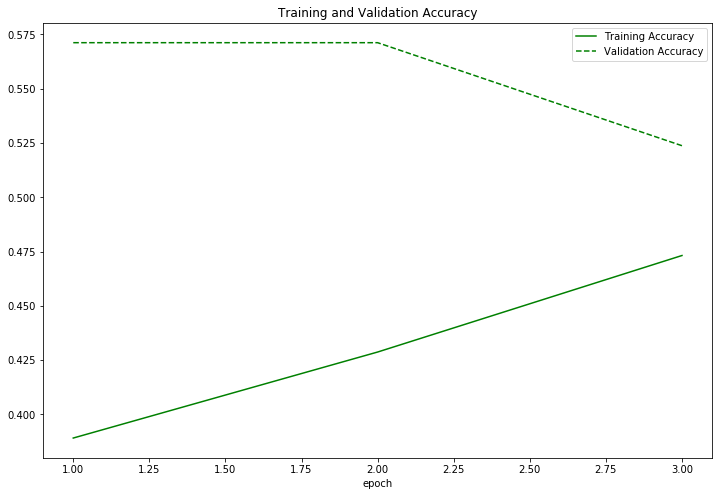

In [268]:
plot_accuracy(history)

In [269]:
# Load model
model = load_keras_model("model_FFNN")

In [271]:
predicted_cols = ['predicted_' + x for x in responses]

The model predictions, shown below, are not very good. This confirms our suspicion that the data were not adequate enough for the network to learn meaningful relationships.

In [272]:
model_predictions = pd.DataFrame(model.predict(X_test), columns=predicted_cols)
test_results = pd.concat([model_predictions, y_test.reset_index(drop=True)], axis=1)

In [273]:
test_results.head()

,predicted_infection_rate,predicted_death_rate,predicted_death_rate_amongst_infected,infection_rate,death_rate,death_rate_amongst_infected
0,-0.000150,0.002810,0.013135,0.000525,0.00000,0.000000
1,-0.002558,0.004251,0.015814,0.000907,0.00000,0.000000
2,-0.000150,0.002810,0.013135,0.000892,0.00000,0.000000
3,-0.000150,0.002810,0.013135,0.000493,0.00000,0.000000
4,-0.002558,0.004251,0.015814,0.000377,0.00002,0.054054


## SHAP Analysis

The analysis below uses [SHAP (SHapley Additive exPlanations)](https://github.com/slundberg/shap), a game theoretic approach to explain the output of machine learning models.

It connects optimal credit allocation with local explanations using the classic Shapley values from game theory and their related extensions. It was developed by Su-In Lee's lab at the University of Washington, and Microsoft Research.

Although the data are poorly-suited to the application of a Feed Forward Neural Network, we still explored the feature importance of the trained model. We used the SHAP (SHapley Additive exPlanations) approach to find the features that most contributed to the model's output.

In [274]:
background = X_train.to_numpy()[np.random.choice(X_train.shape[0], 100, replace=False)]

In [275]:
e = shap.DeepExplainer(model, background)

In [276]:
shap_values = e.shap_values(X_train.to_numpy())

The summary plot below showed some of what we expected, including that the population density, and household value and income (proxies for class) were correlated with higher numbers of cases and deaths. We also found that several policies, like freezing utility shutoffs, closing non-essential business, and banning visitors to nursing homes were also correlated with higher numbers of cases and deaths.

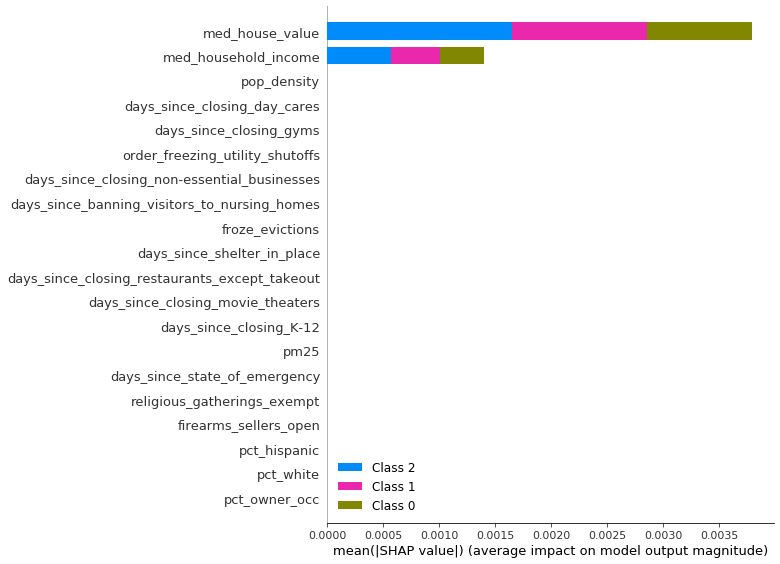

In [277]:
shap.summary_plot(shap_values, X_train)

In [278]:
def plot_shap_dependence(feature, interaction):
    col_index = X_train.columns.get_loc(feature)
    for j, response in enumerate(responses):
        shap.dependence_plot(col_index, shap_values[j], X_train, interaction_index=interaction, show=False)
        plt.title(f"SHAP Values for {response}")
        plt.plot()

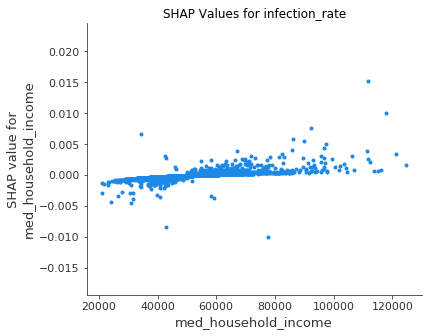

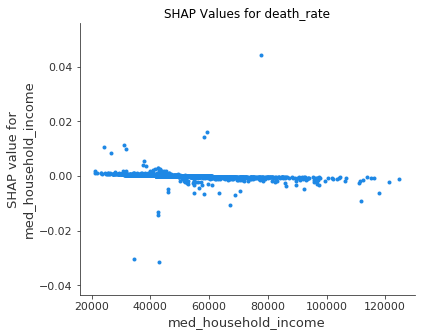

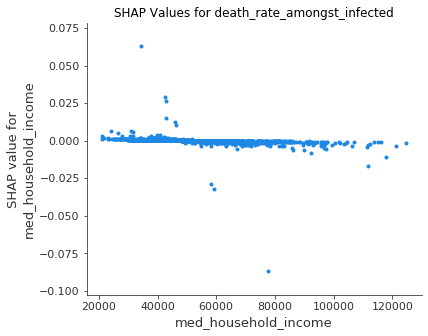

In [281]:
plot_shap_dependence('med_household_income', None)